<a href="https://colab.research.google.com/github/MinseoYoo/Animal-Sentiment-Detection/blob/main/pet_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
import random
import numpy as np
import cv2
import glob
import json
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets
from PIL import Image
import torchvision.transforms as transforms
from tqdm.notebook import tqdm, tqdm_notebook

## catFLW 데이터 로드

In [ ]:
images = []
bboxes = []
labels = []

imgs_list = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/images/*.png'))

for i in range(len(imgs_list)):
    name = imgs_list[i].split('/')[-1][:-4]
    # Read the image
    image = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/images/{name}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(np.asarray(image))

    # Read the labels and bounding boxes from JSON
    with open(f'/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/cat_labeled/labels/{name}.json', 'r') as f:
        data = json.load(f)
        labels.append(data['labels'])
        bboxes.append(data['bounding_boxes'])

bboxes = np.array(bboxes)
labels = np.array(labels)

print(len(images), bboxes.shape, labels.shape)

2079 (2079, 4) (2079, 48, 2)


array([[[115,  85,  87],
        [115,  87,  76],
        [121,  74,  90],
        ...,
        [138, 137, 135],
        [137, 137, 135],
        [137, 137, 135]],

       [[116,  76,  64],
        [107,  95,  71],
        [115,  88,  77],
        ...,
        [138, 138, 136],
        [138, 138, 136],
        [137, 137, 135]],

       [[117,  77,  65],
        [108,  81,  60],
        [101,  68,  63],
        ...,
        [137, 137, 135],
        [136, 136, 134],
        [136, 136, 136]],

       ...,

       [[119,  90,  74],
        [130,  99,  81],
        [118,  95,  54],
        ...,
        [ 45,  19,  18],
        [ 37,  18,  14],
        [ 39,  20,  16]],

       [[ 94,  65,  49],
        [ 95,  59,  59],
        [ 92,  69,  38],
        ...,
        [ 52,  22,  22],
        [ 51,  23,  20],
        [ 53,  27,  14]],

       [[ 93,  62,  44],
        [ 70,  40,  42],
        [ 81,  47,  45],
        ...,
        [ 56,  23,  16],
        [ 56,  25,  22],
        [ 60,  27,  20]]], dtype=uint8)
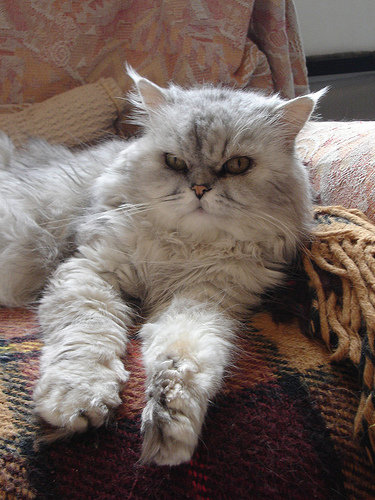

In [ ]:
images[0]

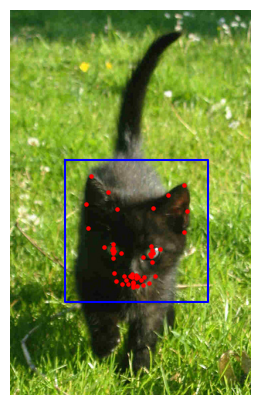

In [ ]:
# Choose a random image
idx = np.random.randint(0, len(images))

# Get the image, landmarks, and bounding box
image = images[idx]
landmarks = labels[idx]
bbox = bboxes[idx]

# Create a figure and plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image)

# Plot the landmarks
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='red')

# Plot the bounding box
plt.plot([bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]],
         [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]],
         c='blue')

plt.axis('off')
# Show the plot
plt.show()

In [ ]:
# dataloader 생성
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Split data into training and validation sets
train_imgs, valid_imgs, train_labels, valid_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Define transformations (optional)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = CatDataset(train_imgs, train_labels, transform=transform)
valid_dataset = CatDataset(valid_imgs, valid_labels, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")


Training dataset size: 1663
Validation dataset size: 416


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 깃허브 모델 사용
https://github.com/nalbert9/Facial-Keypoint-Detection/tree/master

In [ ]:
!git clone https://github.com/nalbert9/Facial-Keypoint-Detection.git

Cloning into 'Facial-Keypoint-Detection'...
remote: Enumerating objects: 5970, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 5970 (delta 11), reused 16 (delta 7), pack-reused 5946
Receiving objects: 100% (5970/5970), 331.56 MiB | 36.92 MiB/s, done.
Resolving deltas: 100% (102/102), done.
Updating files: 100% (5805/5805), done.


In [ ]:
%cd Facial-Keypoint-Detection

/content/Facial-Keypoint-Detection


In [ ]:
from models import Net

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 1)

        self.fc1 = nn.Linear(512*6*6, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 48*2)  # 기존 모델에서 변화한 부분: 플젝 이미지 데이터셋의 keypoint 라벨수와 숫자 맞춤
        self.dropout = nn.Dropout(p=0.25)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
keypoint_model = Net()

In [ ]:
print(keypoint_model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=96, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(keypoint_model.parameters(), lr = 0.001)

In [ ]:
def train_net(model, train_loader, valid_loader, n_epochs, save_path="best_model.pth"):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    train_losses = []
    valid_losses = []
    best_val_loss = float('inf')  # Initialize with infinity

    # loop over the dataset multiple times
    for epoch in tqdm_notebook(range(n_epochs), desc="training"):
        running_loss = 0.0

        # Set the model to training mode
        model.train()

        # train on batches of data
        for batch_i, (images, key_pts) in enumerate(tqdm_notebook(train_loader, desc=f"epoch {epoch}")):
            key_pts = key_pts.view(key_pts.size(0), -1)
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            output_pts = model(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:  # print every 10 batches
                tqdm.write(
                    f"Epoch: {epoch+1}, Batch: {batch_i+1}, Avg. Loss: {running_loss / 10:.4f}"
                )
                running_loss = 0.0

        # Validation step after each epoch
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                images, key_pts = data

                key_pts = key_pts.view(key_pts.size(0), -1)
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

                output_pts = model(images)

                loss = criterion(output_pts, key_pts)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(valid_loader)
        valid_losses.append(avg_val_loss)
        tqdm.write(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}")

        # Save the model if the validation loss is the best we've seen so far.
        if avg_val_loss < best_val_loss:
            tqdm.write(f"Validation loss decreased ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Saving model...")
            best_val_loss = avg_val_loss
            torch.save(model, 'KeypointModel.pth')

    print("Finished Training")
    return train_losses, valid_losses


In [ ]:
train_net(keypoint_model, train_loader, 10)

<ipython-input-33-a48125e48599>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs), desc="training"):


training:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-33-a48125e48599>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_i, (images, key_pts) in enumerate(tqdm_notebook(train_loader, desc=f"epoch {epoch}")):


epoch 0:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1, Batch: 10, Avg. Loss: 19154.2527
Epoch: 1, Batch: 20, Avg. Loss: 23999.1701
Epoch: 1, Batch: 30, Avg. Loss: 21239.2610
Epoch: 1, Batch: 40, Avg. Loss: 20421.6916
Epoch: 1, Batch: 50, Avg. Loss: 19306.9462
Epoch 1, Validation Loss: 20122.6772


epoch 1:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2, Batch: 10, Avg. Loss: 21305.1944
Epoch: 2, Batch: 20, Avg. Loss: 19848.4205
Epoch: 2, Batch: 30, Avg. Loss: 22213.7031
Epoch: 2, Batch: 40, Avg. Loss: 20687.6511
Epoch: 2, Batch: 50, Avg. Loss: 20035.1110
Epoch 2, Validation Loss: 20357.8646


epoch 2:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3, Batch: 10, Avg. Loss: 20032.1312
Epoch: 3, Batch: 20, Avg. Loss: 21546.9785
Epoch: 3, Batch: 30, Avg. Loss: 19144.7990
Epoch: 3, Batch: 40, Avg. Loss: 22671.7082
Epoch: 3, Batch: 50, Avg. Loss: 19561.6978
Epoch 3, Validation Loss: 23874.8249


epoch 3:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4, Batch: 10, Avg. Loss: 20611.2394
Epoch: 4, Batch: 20, Avg. Loss: 20465.2675
Epoch: 4, Batch: 30, Avg. Loss: 22268.6756
Epoch: 4, Batch: 40, Avg. Loss: 20696.9437
Epoch: 4, Batch: 50, Avg. Loss: 19963.8755
Epoch 4, Validation Loss: 19958.6097


epoch 4:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5, Batch: 10, Avg. Loss: 19924.6695
Epoch: 5, Batch: 20, Avg. Loss: 20695.5299
Epoch: 5, Batch: 30, Avg. Loss: 21203.0363
Epoch: 5, Batch: 40, Avg. Loss: 21210.9879
Epoch: 5, Batch: 50, Avg. Loss: 19473.9205
Epoch 5, Validation Loss: 19895.4614


epoch 5:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6, Batch: 10, Avg. Loss: 20843.9271
Epoch: 6, Batch: 20, Avg. Loss: 21163.7170
Epoch: 6, Batch: 30, Avg. Loss: 22020.6521
Epoch: 6, Batch: 40, Avg. Loss: 19338.3794
Epoch: 6, Batch: 50, Avg. Loss: 20726.0650


KeyboardInterrupt: 

In [ ]:
# size debugging
print("Label shape:", labels[0].shape)

Label shape: (48, 2)


In [ ]:
sample_input = torch.randn(1, 1, 224, 224)  # A random input tensor of shape [batch_size, channels, height, width]
sample_output = keypoint_model(sample_input)
print("Model output shape:", sample_output.shape)

Model output shape: torch.Size([1, 136])


## 훈련한 keypoint 모델을 pet facial 데이터에 적용

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = []

        # Gather all image paths and their corresponding labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_names.append(class_name)
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.image_paths[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        label = self.class_names.index(self.labels[self.indices[idx]])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# transforms함수는 위에 정의한 그대로 사용(기존 모델에 맞추기 위해)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# 전부 다 정답값 없기때문에 train/valid/test 나누지 않고 그냥 전체를 eval모드로 키포인트 생성
root_dir = '/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/pet_kaggle'  # Replace with the path to your dataset

dataset = EmotionDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
keypoint_model = torch.load('KeypointModel.pth')

In [ ]:
def save_predictions_to_json(model, data_loader, save_path="predictions.json"):
    model.eval()

    predictions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.type(torch.FloatTensor)

            output_pts = model(images)
            output_pts = output_pts.view(output_pts.size(0), -1)

            output_pts = output_pts.cpu().numpy()
            predictions.append(output_pts.tolist())

    with open(save_path, 'w') as json_file:
        json.dump(predictions, json_file)

    print(f"Predictions saved to {save_path}")

In [ ]:
save_predictions_to_json(keypoint_model, dataloader, save_path="petfacial_keypoint.json")